In [1]:
import numpy as np
import torch


import json
from torch.utils.data import DataLoader
from torch.optim import AdamW,SGD
from torch import nn

from statistics import mean

In [2]:
import utils_generic as generic
import rrnn_modelo as rrnn
import model_confs as confs
import singletask_dep as st

import train

from gensim.models import KeyedVectors

c:\Users\kuina\anaconda3\envs\tfg\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

word2vec_path = r"C:\Users\kuina\gensim-data\word2vec-google-news-300\word2vec-google-news-300.gz"
word2vec_model =  KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

encoding_type = 'absolute'

# Datos ConvAI2

In [4]:
with open('Datasets\ConvAI2\convai2_complete.json','r') as f:
    data = json.load(f)

In [5]:
convai_train = data['train']
convai_val = data['validation']


vocabulary = set(generic.create_word_to_index(convai_train).keys()) & set(word2vec_model.key_to_index.keys())
word_to_index = {}
emb_weights = []
for new_id, word in zip(range(len(vocabulary)),vocabulary):
    word_to_index[word] = new_id
    emb_weights.append(word2vec_model[word])

emb_weights = np.array(emb_weights)



In [6]:
vocab_dep = st.Vocabulary(data['train'],encoding_type)
convai_train_token = generic.tokenize_dataset_with_dependencies_rrnn(convai_train,['about','to','as'],vocab_dep,word_to_index) 
convai_val_token = generic.tokenize_dataset_with_dependencies_rrnn(convai_val,['about','to','as'],vocab_dep,word_to_index) 

In [7]:
convai_train_dataset = {}
for task in ['to','as','about']:
    convai_train_dataset[task] = rrnn.DatasetSingleTaskRRNN(convai_train_token,task,eval=False,deps=True)

In [8]:
convai_val_dataset = {}
for task in ['to','as','about']:
    convai_val_dataset[task] = rrnn.DatasetSingleTaskRRNN(convai_val_token,task,eval=False,deps=True)

# Datos md_gender

In [9]:
with open('Datasets\md_gender\md_complete.json','r',encoding="utf8") as f:
    md_data = json.load(f)

In [10]:
md_tokenized = generic.tokenize_dataset_with_dependencies_rrnn(md_data,['about','to','as'],vocab_dep,word_to_index) 


md_dataset = {}
for task in ['to','as','about']:
    md_dataset[task] = rrnn.DatasetSingleTaskRRNN(md_tokenized,task,eval=True,deps=True)

# Creación dataloaders

In [11]:
dl_train = {}
for task in ['to','as','about']:
    dl_train[task] = DataLoader(convai_train_dataset[task],batch_size=128,shuffle=True,collate_fn=rrnn.collate_fn_dep)

In [12]:
dl_val = {}
for task in ['to','as','about']:
    dl_val[task] = DataLoader(convai_val_dataset[task],batch_size=128,shuffle=True,collate_fn=rrnn.collate_fn_dep)

In [13]:
dl_eval = {}
for task in ['to','as','about']:
    dl_eval[task] = DataLoader(md_dataset[task],batch_size=128,shuffle=False,collate_fn=rrnn.collate_fn_dep)

# Prueba hiperparámetros 1

In [14]:
emb_dim = 20
vocab_size = len(word_to_index)
lstm_hidden_dim = 128

## ABOUT

In [15]:
learning_rate = 5e-5
num_epochs = 100

global_metrics = {'about':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'as':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'to':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}}}

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6809627787576735 	 Validation loss: 0.6810940362639346 	 
  1%|          | 574/57400 [00:06<08:33, 110.74it/s]
Epoch 2 	 Training loss: 0.6675777172585398 	 Validation loss: 0.6588721477379234 	 
  2%|▏         | 1148/57400 [00:11<08:25, 111.21it/s]
Epoch 3 	 Training loss: 0.6519293757058187 	 Validation loss: 0.6496255842305846 	 
  3%|▎         | 1722/57400 [00:17<08:27, 109.68it/s]
Epoch 4 	 Training loss: 0.6436976830926091 	 Validation loss: 0.6435727628610902 	 
  4%|▍         | 2296/57400 [00:23<08:31, 107.72it/s]
Epoch 5 	 Training loss: 0.6366172484819898 	 Validation loss: 0.6358229336092027 	 
  5%|▌         | 2870/57400 [00:28<08:15, 109.96it/s]
Epoch 6 	 Training loss: 0.6299370370467781 	 Validation loss: 0.6297917366027832 	 
  6%|▌         | 3444/57400 [00:34<08:22, 107.30it/s]
Epoch 7 	 Training loss: 0.6230173947919121 	 Validation loss: 0.6231242438494149 	 
  7%|▋         | 4018/57400 [00:40<08:05, 110.02it/s]
Epoch 8 	 Training loss: 0.6

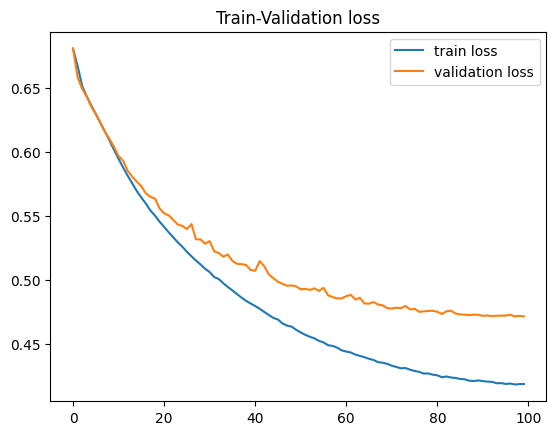

In [16]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path=f'm1_rrnn_{encoding_type}_about_w2v_1'


optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)

In [17]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.7295918367346939, 'precision': 0.7295918367346939, 'f1': 0.7295918367346939, 'accuracy': 0.7295918367346939}
MALE {'recall': 0.796875, 'precision': 0.796875, 'f1': 0.796875, 'accuracy': 0.796875}
FEMALE {'recall': 0.665, 'precision': 0.665, 'f1': 0.665, 'accuracy': 0.665} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.5871212121212122, 'precision': 0.5871212121212122, 'f1': 0.5871212121212122, 'accuracy': 0.5871212121212122}
MALE {'recall': 0.6447688564476886, 'precision': 0.6447688564476886, 'f1': 0.6447688564476886, 'accuracy': 0.6447688564476886}
FEMALE {'recall': 0.5249343832020997, 'precision': 0.5249343832020997, 'f1': 0.5249343832020997, 'accuracy': 0.5249343832020997} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.5997392438070405, 'precision': 0.5997392438070405, 'f1': 0.5997392438070405, 'accuracy': 0.5997392438070405}
MALE {'recall': 0.6540404040404041, 'precision': 0.654040404

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6803991432181634 	 Validation loss: 0.6798226095862308 	 
  1%|          | 574/57400 [00:05<08:48, 107.52it/s]
Epoch 2 	 Training loss: 0.6677843731039492 	 Validation loss: 0.6565864560967785 	 
  2%|▏         | 1148/57400 [00:11<08:43, 107.45it/s]
Epoch 3 	 Training loss: 0.6526425682293828 	 Validation loss: 0.6473627494553388 	 
  3%|▎         | 1722/57400 [00:17<08:46, 105.76it/s]
Epoch 4 	 Training loss: 0.6443397279192762 	 Validation loss: 0.6423665901361886 	 
  4%|▍         | 2296/57400 [00:22<08:28, 108.35it/s]
Epoch 5 	 Training loss: 0.6371574237786934 	 Validation loss: 0.6350281652757677 	 
  5%|▌         | 2870/57400 [00:28<08:21, 108.63it/s]
Epoch 6 	 Training loss: 0.6302000670482888 	 Validation loss: 0.6297072010525202 	 
  6%|▌         | 3444/57400 [00:34<08:15, 108.95it/s]
Epoch 7 	 Training loss: 0.6237917980665945 	 Validation loss: 0.624160885810852 	 
  7%|▋         | 4018/57400 [00:40<08:16, 107.61it/s]
Epoch 8 	 Training loss: 0.61

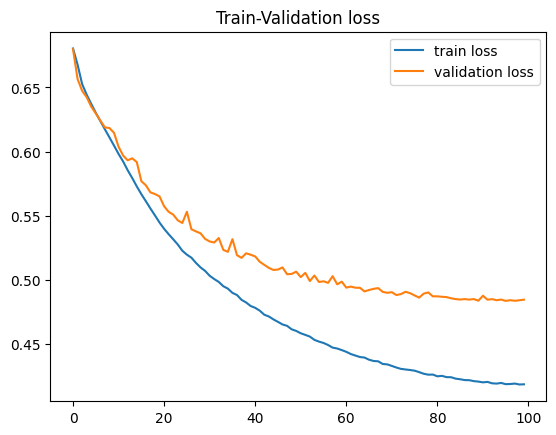

In [18]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path=f'm1_rrnn_{encoding_type}_about_w2v_2'


optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)

In [19]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.7346938775510204, 'precision': 0.7346938775510204, 'f1': 0.7346938775510203, 'accuracy': 0.7346938775510204}
MALE {'recall': 0.8489583333333334, 'precision': 0.8489583333333334, 'f1': 0.8489583333333334, 'accuracy': 0.8489583333333334}
FEMALE {'recall': 0.625, 'precision': 0.625, 'f1': 0.625, 'accuracy': 0.625} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.6047979797979798, 'precision': 0.6047979797979798, 'f1': 0.6047979797979798, 'accuracy': 0.6047979797979798}
MALE {'recall': 0.754257907542579, 'precision': 0.754257907542579, 'f1': 0.754257907542579, 'accuracy': 0.754257907542579}
FEMALE {'recall': 0.4435695538057743, 'precision': 0.4435695538057743, 'f1': 0.4435695538057743, 'accuracy': 0.4435695538057743} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.5801825293350718, 'precision': 0.5801825293350718, 'f1': 0.5801825293350718, 'accuracy': 0.5801825293350718}
MALE {'recall': 0.681818

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6792591742729891 	 Validation loss: 0.6698334075636783 	 
  1%|          | 574/57400 [00:05<09:06, 103.91it/s]
Epoch 2 	 Training loss: 0.6598671909408702 	 Validation loss: 0.6507893699710652 	 
  2%|▏         | 1148/57400 [00:11<08:37, 108.68it/s]
Epoch 3 	 Training loss: 0.6473515953751806 	 Validation loss: 0.6416863728377779 	 
  3%|▎         | 1722/57400 [00:17<08:31, 108.89it/s]
Epoch 4 	 Training loss: 0.6394186865161936 	 Validation loss: 0.6351031327651719 	 
  4%|▍         | 2296/57400 [00:22<08:30, 107.96it/s]
Epoch 5 	 Training loss: 0.6323942953285855 	 Validation loss: 0.6324768207841001 	 
  5%|▌         | 2870/57400 [00:28<08:25, 107.88it/s]
Epoch 6 	 Training loss: 0.625192004940651 	 Validation loss: 0.6223753316927765 	 
  6%|▌         | 3444/57400 [00:34<08:23, 107.16it/s]
Epoch 7 	 Training loss: 0.6182488042095396 	 Validation loss: 0.6198099235356864 	 
  7%|▋         | 4018/57400 [00:39<08:11, 108.56it/s]
Epoch 8 	 Training loss: 0.61

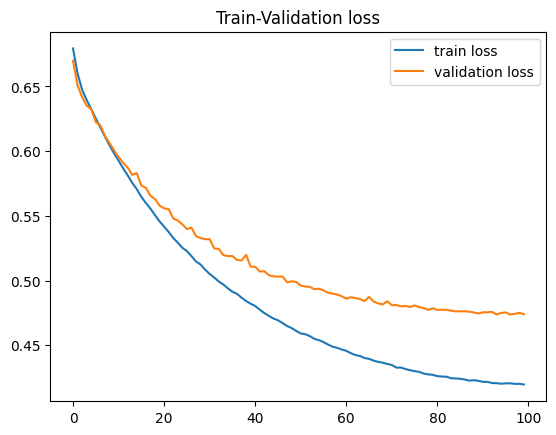

In [20]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path=f'm1_rrnn_{encoding_type}_about_w2v_3'


optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)

In [21]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.7244897959183674, 'precision': 0.7244897959183674, 'f1': 0.7244897959183674, 'accuracy': 0.7244897959183674}
MALE {'recall': 0.8229166666666666, 'precision': 0.8229166666666666, 'f1': 0.8229166666666666, 'accuracy': 0.8229166666666666}
FEMALE {'recall': 0.63, 'precision': 0.63, 'f1': 0.63, 'accuracy': 0.63} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.6111111111111112, 'precision': 0.6111111111111112, 'f1': 0.6111111111111112, 'accuracy': 0.6111111111111112}
MALE {'recall': 0.7128953771289538, 'precision': 0.7128953771289538, 'f1': 0.7128953771289537, 'accuracy': 0.7128953771289538}
FEMALE {'recall': 0.5013123359580053, 'precision': 0.5013123359580053, 'f1': 0.5013123359580053, 'accuracy': 0.5013123359580053} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.5801825293350718, 'precision': 0.5801825293350718, 'f1': 0.5801825293350718, 'accuracy': 0.5801825293350718}
MALE {'recall': 0.666666

In [22]:

print('Métricas globales: \n')

for task in ['about','to','as']:
    print('\n',task)
    print('Resultado global:',{m:mean(values) for m,values in global_metrics[task]['global'].items()})
    print(f'Métricas etiqueta male:',{m:mean(values) for m,values in global_metrics[task]['male'].items()})
    print('Métricas etiqueta female: ',{m:mean(values) for m,values in global_metrics[task]['female'].items()})


Métricas globales: 


 about
Resultado global: {'recall': 0.7295918367346939, 'precision': 0.7295918367346939, 'f1': 0.7295918367346939, 'accuracy': 0.7295918367346939}
Métricas etiqueta male: {'recall': 0.8229166666666666, 'precision': 0.8229166666666666, 'f1': 0.8229166666666666, 'accuracy': 0.8229166666666666}
Métricas etiqueta female:  {'recall': 0.64, 'precision': 0.64, 'f1': 0.64, 'accuracy': 0.64}

 to
Resultado global: {'recall': 0.601010101010101, 'precision': 0.601010101010101, 'f1': 0.601010101010101, 'accuracy': 0.601010101010101}
Métricas etiqueta male: {'recall': 0.7039740470397404, 'precision': 0.7039740470397404, 'f1': 0.7039740470397404, 'accuracy': 0.7039740470397404}
Métricas etiqueta female:  {'recall': 0.4899387576552931, 'precision': 0.4899387576552931, 'f1': 0.4899387576552931, 'accuracy': 0.4899387576552931}

 as
Resultado global: {'recall': 0.5867014341590613, 'precision': 0.5867014341590613, 'f1': 0.5867014341590613, 'accuracy': 0.5867014341590613}
Métricas et

## TO

In [23]:
learning_rate = 1e-6
num_epochs = 100

global_metrics = {'about':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'as':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'to':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}}}

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6934983562093994 	 Validation loss: 0.6940271662453473 	 
  1%|          | 574/57400 [00:05<08:30, 111.36it/s]
Epoch 2 	 Training loss: 0.6935484150768573 	 Validation loss: 0.6944055840120478 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [00:11<08:25, 111.29it/s]
Epoch 3 	 Training loss: 0.6934242718934182 	 Validation loss: 0.6942831399077076 	 

2 epoch without improvement
  3%|▎         | 1722/57400 [00:16<08:12, 113.14it/s]
Epoch 4 	 Training loss: 0.6934705194903583 	 Validation loss: 0.6945287999460252 	 

3 epoch without improvement
  4%|▍         | 2296/57400 [00:22<08:20, 110.13it/s]
Epoch 5 	 Training loss: 0.6934209328910615 	 Validation loss: 0.6945588194717796 	 

4 epoch without improvement
  5%|▌         | 2870/57400 [00:28<08:17, 109.52it/s]
Epoch 6 	 Training loss: 0.6934052554157137 	 Validation loss: 0.6943338604296668 	 

5 epoch without improvement
  6%|▌         | 3444/57400 [00:33<08:09, 110.26it/s]
Epoch 7 	 Training los

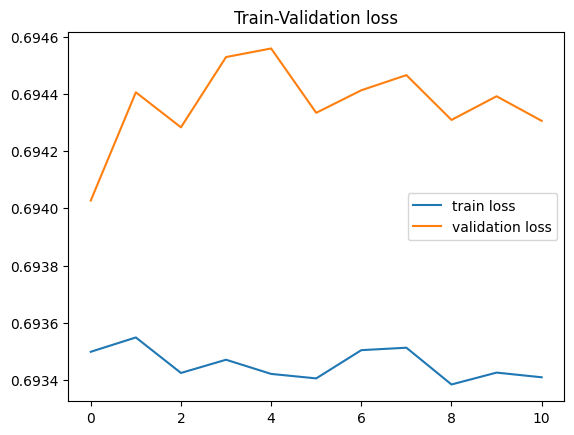

In [24]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path=f'm1_rrnn_{encoding_type}_to_w2v_1'


optimizer = SGD(model.parameters(), lr=learning_rate, momentum=0.9)
train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)

In [25]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.4923469387755102, 'precision': 0.4923469387755102, 'f1': 0.4923469387755102, 'accuracy': 0.4923469387755102}
MALE {'recall': 0.9791666666666666, 'precision': 0.9791666666666666, 'f1': 0.9791666666666666, 'accuracy': 0.9791666666666666}
FEMALE {'recall': 0.025, 'precision': 0.025, 'f1': 0.025000000000000005, 'accuracy': 0.025} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.5202020202020202, 'precision': 0.5202020202020202, 'f1': 0.5202020202020202, 'accuracy': 0.5202020202020202}
MALE {'recall': 0.9829683698296837, 'precision': 0.9829683698296837, 'f1': 0.9829683698296837, 'accuracy': 0.9829683698296837}
FEMALE {'recall': 0.02099737532808399, 'precision': 0.02099737532808399, 'f1': 0.02099737532808399, 'accuracy': 0.02099737532808399} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.5084745762711864, 'precision': 0.5084745762711864, 'f1': 0.5084745762711864, 'accuracy': 0.5084745762711864}
M

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6932359386611898 	 Validation loss: 0.6935831116417707 	 
  1%|          | 574/57400 [00:05<08:41, 108.97it/s]
Epoch 2 	 Training loss: 0.6932552641692478 	 Validation loss: 0.6936048188451993 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [00:11<08:27, 110.83it/s]
Epoch 3 	 Training loss: 0.6932448339794571 	 Validation loss: 0.6937875777988111 	 

2 epoch without improvement
  3%|▎         | 1722/57400 [00:17<08:20, 111.27it/s]
Epoch 4 	 Training loss: 0.6932555160871366 	 Validation loss: 0.6937138953451383 	 

3 epoch without improvement
  4%|▍         | 2296/57400 [00:22<08:22, 109.66it/s]
Epoch 5 	 Training loss: 0.6932895656039075 	 Validation loss: 0.6935636067794542 	 
  5%|▌         | 2870/57400 [00:28<08:09, 111.34it/s]
Epoch 6 	 Training loss: 0.6932186725247612 	 Validation loss: 0.6935808395935317 	 

1 epoch without improvement
  6%|▌         | 3444/57400 [00:33<08:03, 111.52it/s]
Epoch 7 	 Training loss: 0.6932061950088794 	 Valid

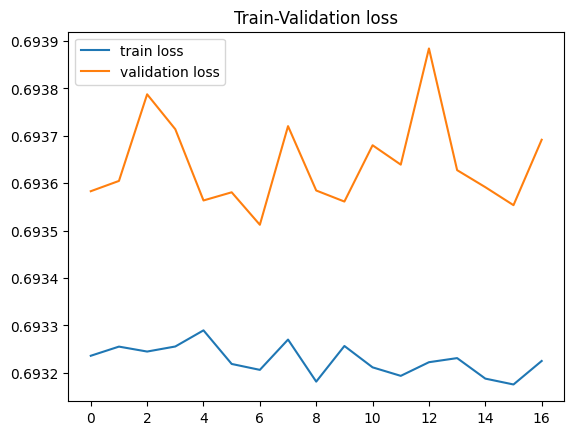

In [26]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path=f'm1_rrnn_{encoding_type}_to_w2v_2'


optimizer = SGD(model.parameters(), lr=learning_rate, momentum=0.9)
train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)

In [27]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.5178571428571429, 'precision': 0.5178571428571429, 'f1': 0.5178571428571429, 'accuracy': 0.5178571428571429}
MALE {'recall': 0.8645833333333334, 'precision': 0.8645833333333334, 'f1': 0.8645833333333333, 'accuracy': 0.8645833333333334}
FEMALE {'recall': 0.185, 'precision': 0.185, 'f1': 0.185, 'accuracy': 0.185} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.5404040404040404, 'precision': 0.5404040404040404, 'f1': 0.5404040404040404, 'accuracy': 0.5404040404040404}
MALE {'recall': 0.8710462287104623, 'precision': 0.8710462287104623, 'f1': 0.8710462287104623, 'accuracy': 0.8710462287104623}
FEMALE {'recall': 0.1837270341207349, 'precision': 0.1837270341207349, 'f1': 0.1837270341207349, 'accuracy': 0.1837270341207349} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.4915254237288136, 'precision': 0.4915254237288136, 'f1': 0.4915254237288136, 'accuracy': 0.4915254237288136}
MALE {'recall': 0.79

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6940473358597905 	 Validation loss: 0.6918842731896093 	 
  1%|          | 574/57400 [00:05<08:26, 112.26it/s]
Epoch 2 	 Training loss: 0.6938943656271759 	 Validation loss: 0.6914350511664051 	 
  2%|▏         | 1148/57400 [00:11<08:23, 111.71it/s]
Epoch 3 	 Training loss: 0.6939226343241303 	 Validation loss: 0.6906014983936891 	 
  3%|▎         | 1722/57400 [00:17<08:29, 109.39it/s]
Epoch 4 	 Training loss: 0.6939259956522685 	 Validation loss: 0.6910100973258584 	 

1 epoch without improvement
  4%|▍         | 2296/57400 [00:22<08:12, 111.92it/s]
Epoch 5 	 Training loss: 0.6939580214148199 	 Validation loss: 0.6910097154520326 	 

2 epoch without improvement
  5%|▌         | 2870/57400 [00:28<08:20, 108.94it/s]
Epoch 6 	 Training loss: 0.6942677051348138 	 Validation loss: 0.6916065014014809 	 

3 epoch without improvement
  6%|▌         | 3444/57400 [00:33<08:06, 110.84it/s]
Epoch 7 	 Training loss: 0.6939899694005787 	 Validation loss: 0.691912202511803

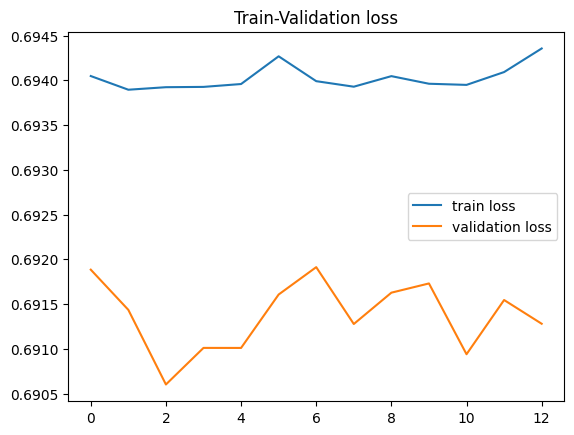

In [28]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path=f'm1_rrnn_{encoding_type}_to_w2v_3'


optimizer = SGD(model.parameters(), lr=learning_rate, momentum=0.9)
train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)

In [29]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.5102040816326531, 'precision': 0.5102040816326531, 'f1': 0.5102040816326531, 'accuracy': 0.5102040816326531}
MALE {'recall': 0.0, 'precision': 0.0, 'f1': 0.0, 'accuracy': 0.0}
FEMALE {'recall': 1.0, 'precision': 1.0, 'f1': 1.0, 'accuracy': 1.0} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.4810606060606061, 'precision': 0.4810606060606061, 'f1': 0.4810606060606061, 'accuracy': 0.4810606060606061}
MALE {'recall': 0.0, 'precision': 0.0, 'f1': 0.0, 'accuracy': 0.0}
FEMALE {'recall': 1.0, 'precision': 1.0, 'f1': 1.0, 'accuracy': 1.0} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.48370273794002605, 'precision': 0.48370273794002605, 'f1': 0.48370273794002605, 'accuracy': 0.48370273794002605}
MALE {'recall': 0.0, 'precision': 0.0, 'f1': 0.0, 'accuracy': 0.0}
FEMALE {'recall': 1.0, 'precision': 1.0, 'f1': 1.0, 'accuracy': 1.0} 



In [30]:

print('Métricas globales: \n')

for task in ['about','to','as']:
    print('\n',task)
    print('Resultado global:',{m:mean(values) for m,values in global_metrics[task]['global'].items()})
    print(f'Métricas etiqueta male:',{m:mean(values) for m,values in global_metrics[task]['male'].items()})
    print('Métricas etiqueta female: ',{m:mean(values) for m,values in global_metrics[task]['female'].items()})


Métricas globales: 


 about
Resultado global: {'recall': 0.5068027210884354, 'precision': 0.5068027210884354, 'f1': 0.5068027210884354, 'accuracy': 0.5068027210884354}
Métricas etiqueta male: {'recall': 0.6145833333333334, 'precision': 0.6145833333333334, 'f1': 0.6145833333333333, 'accuracy': 0.6145833333333334}
Métricas etiqueta female:  {'recall': 0.4033333333333333, 'precision': 0.4033333333333333, 'f1': 0.4033333333333333, 'accuracy': 0.4033333333333333}

 to
Resultado global: {'recall': 0.513888888888889, 'precision': 0.513888888888889, 'f1': 0.513888888888889, 'accuracy': 0.513888888888889}
Métricas etiqueta male: {'recall': 0.6180048661800487, 'precision': 0.6180048661800487, 'f1': 0.6180048661800487, 'accuracy': 0.6180048661800487}
Métricas etiqueta female:  {'recall': 0.4015748031496063, 'precision': 0.4015748031496063, 'f1': 0.4015748031496063, 'accuracy': 0.4015748031496063}

 as
Resultado global: {'recall': 0.494567579313342, 'precision': 0.494567579313342, 'f1': 0.4945675

# AS

In [31]:
learning_rate = 5e-5
num_epochs = 100

global_metrics = {'about':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'as':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'to':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}}}

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6933191759245736 	 Validation loss: 0.6940138309688891 	 
  1%|          | 574/57400 [00:06<09:34, 98.97it/s]
Epoch 2 	 Training loss: 0.6932900799276106 	 Validation loss: 0.6925090622093718 	 
  2%|▏         | 1148/57400 [00:12<09:31, 98.48it/s]
Epoch 3 	 Training loss: 0.6931565837993023 	 Validation loss: 0.6925943998967187 	 

1 epoch without improvement
  3%|▎         | 1722/57400 [00:19<09:22, 98.94it/s]
Epoch 4 	 Training loss: 0.6931318999998245 	 Validation loss: 0.6924950844150478 	 
  4%|▍         | 2296/57400 [00:25<09:20, 98.27it/s]
Epoch 5 	 Training loss: 0.6931034030606937 	 Validation loss: 0.6928137247845277 	 

1 epoch without improvement
  5%|▌         | 2870/57400 [00:31<09:17, 97.77it/s]
Epoch 6 	 Training loss: 0.693012350527667 	 Validation loss: 0.6922305226325989 	 
  6%|▌         | 3444/57400 [00:38<09:12, 97.67it/s]
Epoch 7 	 Training loss: 0.6930382869592527 	 Validation loss: 0.6926648879455308 	 

1 epoch without improvement
  

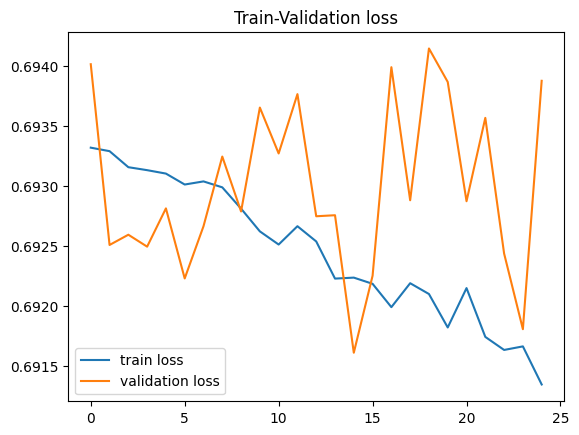

In [32]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path=f'm1_rrnn_{encoding_type}_as_w2v_1'


optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path,es_threshold=0)

In [33]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.5165816326530612, 'precision': 0.5165816326530612, 'f1': 0.5165816326530612, 'accuracy': 0.5165816326530612}
MALE {'recall': 0.3072916666666667, 'precision': 0.3072916666666667, 'f1': 0.3072916666666667, 'accuracy': 0.3072916666666667}
FEMALE {'recall': 0.7175, 'precision': 0.7175, 'f1': 0.7175, 'accuracy': 0.7175} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.4962121212121212, 'precision': 0.4962121212121212, 'f1': 0.4962121212121212, 'accuracy': 0.4962121212121212}
MALE {'recall': 0.340632603406326, 'precision': 0.340632603406326, 'f1': 0.340632603406326, 'accuracy': 0.340632603406326}
FEMALE {'recall': 0.6640419947506562, 'precision': 0.6640419947506562, 'f1': 0.6640419947506562, 'accuracy': 0.6640419947506562} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.5202086049543677, 'precision': 0.5202086049543677, 'f1': 0.5202086049543677, 'accuracy': 0.5202086049543677}
MALE {'recall': 0.35

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6933814965266384 	 Validation loss: 0.6933153009010573 	 
  1%|          | 574/57400 [00:06<09:23, 100.92it/s]
Epoch 2 	 Training loss: 0.6932387591862097 	 Validation loss: 0.6923196487507578 	 
  2%|▏         | 1148/57400 [00:12<09:17, 100.85it/s]
Epoch 3 	 Training loss: 0.6931538358590329 	 Validation loss: 0.6921529396105621 	 
  3%|▎         | 1722/57400 [00:18<09:26, 98.25it/s]
Epoch 4 	 Training loss: 0.6931787281709265 	 Validation loss: 0.6925648551876262 	 

1 epoch without improvement
  4%|▍         | 2296/57400 [00:24<09:20, 98.36it/s]
Epoch 5 	 Training loss: 0.6930800190370673 	 Validation loss: 0.6924432748455113 	 

2 epoch without improvement
  5%|▌         | 2870/57400 [00:31<09:11, 98.92it/s]
Epoch 6 	 Training loss: 0.6929919959568396 	 Validation loss: 0.6928184830536277 	 

3 epoch without improvement
  6%|▌         | 3444/57400 [00:37<09:02, 99.50it/s]
Epoch 7 	 Training loss: 0.6931046920370972 	 Validation loss: 0.6936459147323997 	 

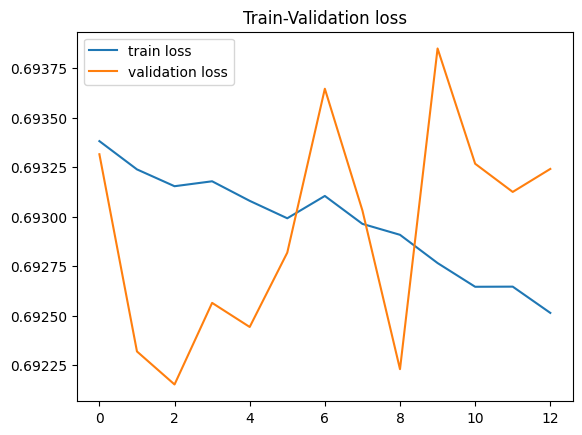

In [34]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path=f'm1_rrnn_{encoding_type}_as_w2v_2'


optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path,es_threshold=0)

In [35]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.5076530612244898, 'precision': 0.5076530612244898, 'f1': 0.5076530612244898, 'accuracy': 0.5076530612244898}
MALE {'recall': 0.0, 'precision': 0.0, 'f1': 0.0, 'accuracy': 0.0}
FEMALE {'recall': 0.995, 'precision': 0.995, 'f1': 0.995, 'accuracy': 0.995} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.4797979797979798, 'precision': 0.4797979797979798, 'f1': 0.4797979797979798, 'accuracy': 0.4797979797979798}
MALE {'recall': 0.0, 'precision': 0.0, 'f1': 0.0, 'accuracy': 0.0}
FEMALE {'recall': 0.9973753280839895, 'precision': 0.9973753280839895, 'f1': 0.9973753280839895, 'accuracy': 0.9973753280839895} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.48239895697522817, 'precision': 0.48239895697522817, 'f1': 0.48239895697522817, 'accuracy': 0.48239895697522817}
MALE {'recall': 0.0, 'precision': 0.0, 'f1': 0.0, 'accuracy': 0.0}
FEMALE {'recall': 0.9973045822102425, 'precision': 0.9973045822102425

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6932547534799742 	 Validation loss: 0.6930281317840188 	 
  1%|          | 574/57400 [00:06<09:28, 99.96it/s]
Epoch 2 	 Training loss: 0.6931622633742954 	 Validation loss: 0.6938129693774854 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [00:12<09:26, 99.24it/s]
Epoch 3 	 Training loss: 0.693162700544251 	 Validation loss: 0.6935071187504267 	 

2 epoch without improvement
  3%|▎         | 1722/57400 [00:18<09:19, 99.52it/s]
Epoch 4 	 Training loss: 0.6930595590677826 	 Validation loss: 0.6932507399785317 	 

3 epoch without improvement
  4%|▍         | 2296/57400 [00:24<09:01, 101.79it/s]
Epoch 5 	 Training loss: 0.6930149346070837 	 Validation loss: 0.6933353715023752 	 

4 epoch without improvement
  5%|▌         | 2870/57400 [00:31<09:14, 98.41it/s]
Epoch 6 	 Training loss: 0.692897426126726 	 Validation loss: 0.6928095797360954 	 
  6%|▌         | 3444/57400 [00:37<09:16, 96.92it/s]
Epoch 7 	 Training loss: 0.6930348890791371 	 Validation l

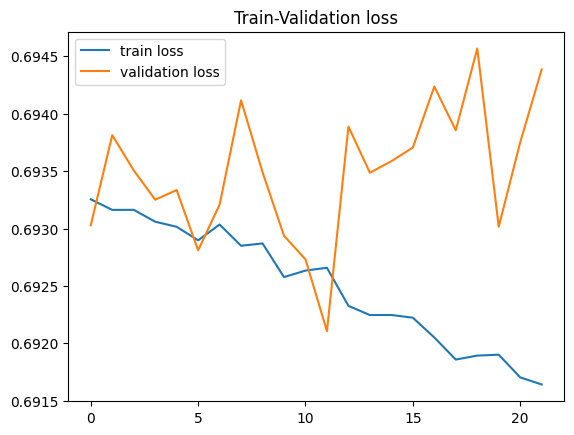

In [36]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path=f'm1_rrnn_{encoding_type}_as_w2v_3'


optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path,es_threshold=0)

In [37]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.5, 'precision': 0.5, 'f1': 0.5, 'accuracy': 0.5}
MALE {'recall': 0.3255208333333333, 'precision': 0.3255208333333333, 'f1': 0.3255208333333333, 'accuracy': 0.3255208333333333}
FEMALE {'recall': 0.6675, 'precision': 0.6675, 'f1': 0.6675, 'accuracy': 0.6675} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.5265151515151515, 'precision': 0.5265151515151515, 'f1': 0.5265151515151515, 'accuracy': 0.5265151515151515}
MALE {'recall': 0.36253041362530414, 'precision': 0.36253041362530414, 'f1': 0.3625304136253041, 'accuracy': 0.36253041362530414}
FEMALE {'recall': 0.7034120734908137, 'precision': 0.7034120734908137, 'f1': 0.7034120734908137, 'accuracy': 0.7034120734908137} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.5332464146023468, 'precision': 0.5332464146023468, 'f1': 0.5332464146023468, 'accuracy': 0.5332464146023468}
MALE {'recall': 0.3409090909090909, 'precision': 0.3409090909090909, 'f1'

In [38]:

print('Métricas globales: \n')

for task in ['about','to','as']:
    print('\n',task)
    print('Resultado global:',{m:mean(values) for m,values in global_metrics[task]['global'].items()})
    print(f'Métricas etiqueta male:',{m:mean(values) for m,values in global_metrics[task]['male'].items()})
    print('Métricas etiqueta female: ',{m:mean(values) for m,values in global_metrics[task]['female'].items()})


Métricas globales: 


 about
Resultado global: {'recall': 0.5080782312925171, 'precision': 0.5080782312925171, 'f1': 0.5080782312925171, 'accuracy': 0.5080782312925171}
Métricas etiqueta male: {'recall': 0.2109375, 'precision': 0.2109375, 'f1': 0.2109375, 'accuracy': 0.2109375}
Métricas etiqueta female:  {'recall': 0.7933333333333333, 'precision': 0.7933333333333333, 'f1': 0.7933333333333333, 'accuracy': 0.7933333333333333}

 to
Resultado global: {'recall': 0.5008417508417509, 'precision': 0.5008417508417509, 'f1': 0.5008417508417509, 'accuracy': 0.5008417508417509}
Métricas etiqueta male: {'recall': 0.23438767234387672, 'precision': 0.23438767234387672, 'f1': 0.2343876723438767, 'accuracy': 0.23438767234387672}
Métricas etiqueta female:  {'recall': 0.7882764654418198, 'precision': 0.7882764654418198, 'f1': 0.7882764654418198, 'accuracy': 0.7882764654418198}

 as
Resultado global: {'recall': 0.5119513255106476, 'precision': 0.5119513255106476, 'f1': 0.5119513255106476, 'accuracy': 0.51